In [1]:
import numpy as np
import pandas as pd
import math
import scipy
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import scipy.integrate as integrate


# Q1: Coin toss

Read section 2.1 of Sivia and recreate figure 2.3.

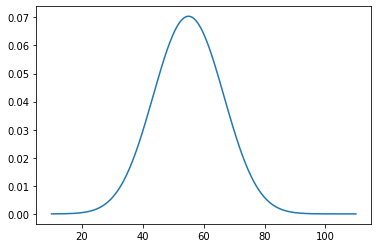

In [2]:
from scipy.interpolate import UnivariateSpline
def make_norm_dist(x, mean, sd):
    return 1.0/(sd*np.sqrt(2*np.pi))*np.exp(-(x - mean)**2/(2*sd**2))

x = np.linspace(10, 110, 1000)
g = make_norm_dist(x, 50, 10)
p = make_norm_dist(x, 60, 10)
b = g + p   
spline = UnivariateSpline(x, b-np.max(b)/2, s=0)

import pylab as pl
pl.plot(x, b)
pl.show()

## (a)

Define the prior functions

In [3]:
def uniform_prior(H):
    if  H > 1 or H < 0:
        return 0

    return 1
    
first_prior = np.vectorize(uniform_prior)
    

def gaussian_prior(H):
    if  H > 1 or H < 0:
        return 0
    
    sigma = 0.03
    mu = 0.5
    
    return ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (H - mu))**2))

second_prior = np.vectorize(gaussian_prior)


def third_prior(H):
     if  H > 1 or H < 0:
         return 0
     mu1 = 0
     mu2 = 1
     sigma = 0.02

     return ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (H - mu1))**2)) + ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (H - mu2))**2))

third_prior = np.vectorize(third_prior)

### Bonus point

Why do we need to use np.vectorize here?

In [4]:
#Vectorization is used to speed up the Python code without using loop. Using such a function can help in minimizing the running time of code efficiently. 

## (b)

Create an array for H, calculte the priors, normalize them and then plot them.

In [5]:
H = np.linspace(0, 1, 1000, dtype=np.float128)

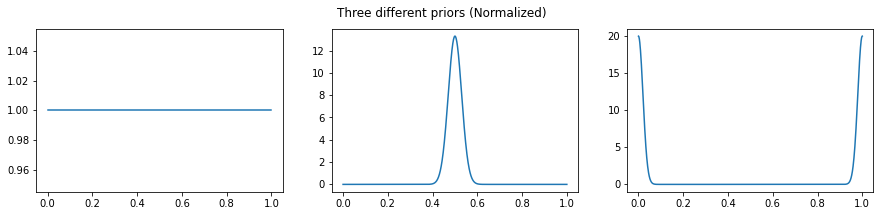

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
plt.suptitle('Three different priors (Normalized)')

ax1.plot(H, first_prior(H))
ax2.plot(H, second_prior(H))
ax3.plot(H, third_prior(H))


plt.show()

## (c)

Here we explicitly declared a data type for the array H. Although most of the times python does it for us, here was an example that we need to do it by hand to avoid round-off error. Find out what this error is and write a few lines about it (In Farsi or English) and explain what did we do to avoid it here. In other words, why did we use 'np.float128' exept just using 'float'?

You can also emit the data type decleration from the definition of H and see what happens in calculating the posterior.

In [7]:
#np. float128 provide more precision than float. 128 bits represents large amount of data and it helps us for analysing data.

## (d)

Write a proper function to calculate the psterior for a given data and recreate the given plot.

In [8]:
data = [np.random.choice([0, 0, 0, 0, 0, 0, 0, 1, 1, 1], size=(i)) for i in range(4)]  
data.extend([np.random.choice([0, 0, 0, 0, 0, 0, 0, 1, 1, 1], size=(2**i)) for i in range(2, 13)])

In [9]:
data

[array([], dtype=int64),
 array([0]),
 array([1, 0]),
 array([1, 0, 1]),
 array([0, 0, 0, 0]),
 array([0, 1, 0, 0, 0, 0, 0, 0]),
 array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 array([0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]),
 array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 

In [14]:
def posterior(prior, data , H):

    def likelihood(H, data):
        R = sum(data)
        N = len(data)
        return (H**R)*((1-H)**(N-R))

    def priorlikelihood(H, data):
        return prior(H)*likelihood(H, data)
    
    def normal(H, data):
        dh = H[1]-H[0]
        return sum(priorlikelihood(H[:-1], data))*dh

    return priorlikelihood(H, data)/normal(H, data)

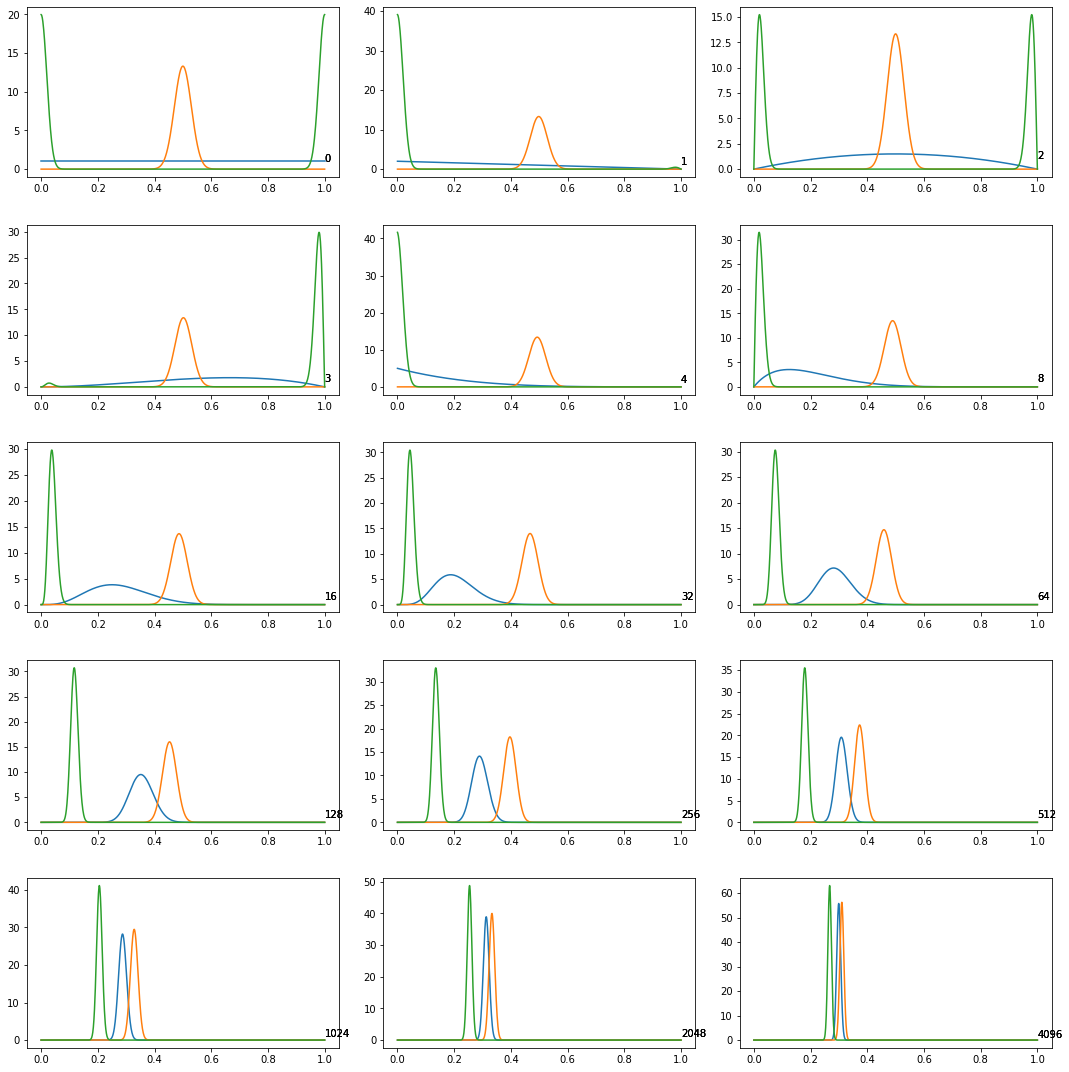

In [16]:
fig, axs = plt.subplots(5, 3, figsize= (15,15))
for i in range(15):
    for j in [first_prior , second_prior, third_prior]:
        axs.flatten()[i].plot(H, posterior(j, data[i], H))
        axs.flatten()[i].text(1,1, str(len(data[i])))

plt.tight_layout(h_pad=3)
plt.show()

# Q2: Distributions and moments

## (a)

Write a function to calculate raw moments of a given distribution 

In [17]:
def raw_moment(x, r = 1):
    n = len(x)
    return (sum(i**r for i in x))/n
    


## (b)

Write a function to calculate central moments of a given distribution

In [18]:
def central_moment(x, r = 1):
    xbar = x.mean()
    n = len(x)
    return (sum((i-xbar)**r for i in x))/n

## (c)

Using numpy.random, create a binomial (p=0.7, n=$30$), a Poisson ($\mu$ = 2.1) and a gaussian ($\mu$ = 2.1, $\sigma = 0.3$) distribution with size $10^6$ and calculate their first 3 raw and central moments

In [19]:
binomial = np.random.binomial(30, 0.7, 10**6)
poisson = np.random.poisson(2.1, 10**6)
gaussian = np.random.normal(2.1 , 0.3 , 10**6)


In [20]:
for i in range (1,4):
    for j in [binomial, poisson, gaussian]:
        print('raw moment', i, ':' , raw_moment(j, i))

raw moment 1 : 20.998728
raw moment 1 : 2.101495
raw moment 1 : 2.0993961464846875
raw moment 2 : 447.23963
raw moment 2 : 6.521311
raw moment 2 : 4.497542905096264
raw moment 3 : 9653.236686
raw moment 3 : 24.670945
raw moment 3 : 9.820505263471658


In [21]:
for i in range (1,4):
    for j in [binomial, poisson, gaussian]:
        print('Central Moment', i, ':' , central_moment(j, i))

Central Moment 1 : -2.4309457558047143e-14
Central Moment 1 : 2.912622676376486e-14
Central Moment 1 : 9.111233989500534e-16
Central Moment 2 : 6.29305238198701
Central Moment 2 : 2.1050297649837346
Central Moment 2 : 0.09007872522153482
Central Moment 3 : -2.518845710057515
Central Moment 3 : 2.119023488186508
Central Moment 3 : 0.0001591626422624023


## (d)

Using scipy.stats, calculate the first three moments of these distributions and check with the results from your own function. What does the function in scipy calculate? Raw moments or central moments?

In [23]:
for i in range (1,4):
    for j in [binomial, poisson, gaussian]:
        print(stats.moment(j,i))

0.0
0.0
0.0
6.293052382016
2.105029764975
0.0900787252215322
-2.518845710052147
2.1190234881627257
0.00015916264226239495


# Q3: Radioactive decay

The Poisson distribution is often used to describe situations in which an event occurs repeatedly at a constant rate of probability. An application of this distribution involves the decay of radioactive samples, but only in the approximation that the decay rate is slow enough that depletion in the population of the decaying species can be neglected.

Now suppose we have a data set showing the number of $\alpha$ particles emmited in 7.5 sec intervals:

## (a)

Load the provided data into a pandas data frame and show the data and then plot it's PDF.

In [24]:
data = pd.read_csv("/data.txt", sep=('	'))
data

,# time passed,number of events
0,7.5,232.0
1,15.0,240.0
2,22.5,245.0
3,30.0,226.0
4,37.5,223.0
...,...,...
2043,15330.0,265.0
2044,15337.5,220.0
2045,15345.0,252.0
2046,15352.5,229.0


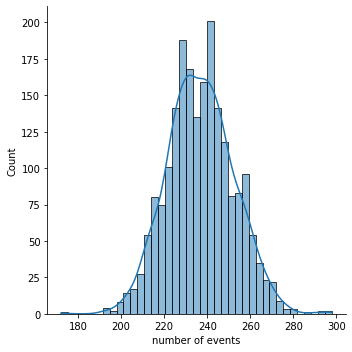

In [25]:
sns.displot(data['number of events'], kde = True)

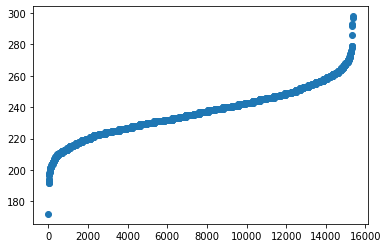

In [26]:
plt.plot(data['# time passed'], data['number of events'].sort_values(), 'o')

## (b)

Calculate total number of decays and the average number of decays after each time interval. Then add the data to the Pandas DataFrame and show it. Then save the data to file 'new_data.txt'.

In [27]:
data['total number'] = [sum(data['number of events'][:i]) for i in range(1, 2049)]
data['average number'] = data['total number']/7.5
data

,# time passed,number of events,total number,average number
0,7.5,232.0,232.0,30.933333
1,15.0,240.0,472.0,62.933333
2,22.5,245.0,717.0,95.600000
3,30.0,226.0,943.0,125.733333
4,37.5,223.0,1166.0,155.466667
...,...,...,...,...
2043,15330.0,265.0,484278.0,64570.400000
2044,15337.5,220.0,484498.0,64599.733333
2045,15345.0,252.0,484750.0,64633.333333
2046,15352.5,229.0,484979.0,64663.866667


In [28]:
data.to_csv('new_data.txt')

## (c)

Use a unifor prior and do the same analysis as question 1 to get the mean decay number per interval. Plot the diagrams as well. (Beware that this time we have a Poisson distribution rather than a binomial one)

In [29]:
def uniform_prior(H):
    if H<0 or H>50:
       return 0 
    return 1
priorx = np.vectorize(uniform_prior)

## (d)

Use two different priors of your choise and repeat the analysis. Which of these three priors leads to an answer sooner?

## (e)

Now that you have the average decay per time interval, calculate the half life of this radioactive element (Suppose that the sample is large enough not to lose a noticable fraction of the particles in the span of the experiment). Can find out what this element is?

# Bonus question

Do an error analysis and report how sure are you about the number you derived for the half life of the element.